# The 20 newsgroups text dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date. We must **classify the topics of news according to its content**. 

The dataset is organized by scikit-learn package,and we can use some functions to fetech them. To simplify our problem, we take 3 topics as our data for analysis.


In [1]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint 

# choose atheism, graphics, sport as our news data
cats = ['alt.atheism', 'comp.graphics', 'rec.motorcycles']

# fetch the data from 20newsgroup
newsgroup_train = fetch_20newsgroups(subset = 'train', categories = cats,remove=('headers', 'footers', 'quotes'), )
newsgroup_test = fetch_20newsgroups(subset = 'test', categories = cats,remove=('headers', 'footers', 'quotes'), )

## Show the names and numbers of each category

In [2]:
import collections
# show topic name of data 
num_topic_train = collections.Counter(newsgroup_train.target)
num_topic_test = collections.Counter(newsgroup_test.target)
print('category list : {}'.format(newsgroup_train.target_names))

# show number of each topic data
print('-------------number of each category-----------------')

print("train data")
for i in range(3):
    print('{} on {} '.format(num_topic_train[i],newsgroup_train.target_names[i]))
print()
print("test data")    
for i in range(3):
    print('{} on {} '.format(num_topic_test[i],newsgroup_test.target_names[i]))
    
    
print('------------------------------------------------------')

category list : ['alt.atheism', 'comp.graphics', 'rec.motorcycles']
-------------number of each category-----------------
train data
480 on alt.atheism 
584 on comp.graphics 
598 on rec.motorcycles 

test data
319 on alt.atheism 
389 on comp.graphics 
398 on rec.motorcycles 
------------------------------------------------------


## Data processing 
The raw texts from 20 newsgroups dataset have many stopwords and no-stemmed words.Therefore, we have to clean the data and preserve the significant information.

### * Stop word
Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called **stop words**.The general strategy for determining a stop list is to sort the terms by collection frequency (the total number of times each term appears in the document collection), and then to take the most frequent terms, often hand-filtered for their semantic content relative to the domain of the documents being indexed, as a **stop list** 
### * Stemming
For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set. If we don't stem the words in the raw text, we could not remove some stop words beacuse of different forms not recorded in stop list.



In [3]:
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

stemmer = SnowballStemmer("english")
StopWords = set(stopwords.words('english'))
replace_numbers=re.compile(r'\d+',re.IGNORECASE)
special_character_removal=re.compile(r'[^a-z\d\n ]',re.IGNORECASE)

In [4]:
def clean_text(text, stem_words=True):
    # Clean the text, with the option to remove stopwords and to stem words.
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    text = special_character_removal.sub('',text)

    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        clean_words = [word for word in stemmed_words if word not in StopWords]
        text = " ".join(clean_words)

    return text

In [5]:
newsgroup_clean_train_data = []
newsgroup_clean_test_data = []
for text in newsgroup_train.data : 
    text = clean_text(text)
    newsgroup_clean_train_data.append(text)
    
for text in newsgroup_test.data : 
    text = clean_text(text)
    newsgroup_clean_test_data.append(text)

## Use the GloVe pre-trained vector to transfer text to a dense vector 
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.The pre-trained Glove vector is available [here](https://nlp.stanford.edu/projects/glove/) and we sum all vectors of all the words in the document. 

In [7]:
import gensim
import numpy as np
model = gensim.models.KeyedVectors.load_word2vec_format('./glove.twitter.27B/glove_vec',binary=False) #GloVe Model

def glove_vec(text):
    # transfer text to word list
    text = text.split()
    word_count = 0 
    doc_vec = None
    
    # sum all the words in the text
    for word in text :
        try:
            if word_count == 0:
                doc_vec = model[word]
            else:
                doc_vec = doc_vec + model[word]
            word_count += 1
        
        except:
            pass
    
    if word_count == 0:
        return np.zeros(100)
    
    else :
        return doc_vec / word_count    

train_glove_vec = []
test_glove_vec = []
for i,text in enumerate(newsgroup_clean_train_data):
    vec = glove_vec(text)
    train_glove_vec.append(vec)

for i,text in enumerate(newsgroup_clean_test_data):
    vec = glove_vec(text)
    test_glove_vec.append(vec)

train_glove_vec = np.array(train_glove_vec)
test_glove_vec = np.array(test_glove_vec)

## Visualize the Glove result in 2-D space
we use PCA to reduce sparse vectors to 2-dims vectors and put them into 2D-space. The following figure shows the points from each news have better clustering property than BOW

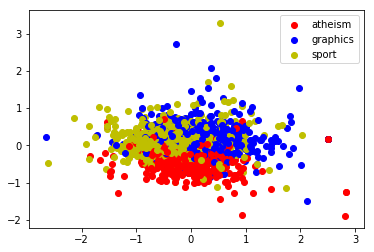

In [10]:
from sklearn.decomposition import PCA
import  matplotlib.pyplot as plt
pca=PCA(n_components=2)
train_glove_vec_pca = pca.fit_transform(train_glove_vec)
plt.figure()
for i in range(len(train_glove_vec)):
    if newsgroup_train.target[i] == 0:
        topic1 = plt.scatter(train_glove_vec_pca[i][0], train_glove_vec_pca[i][1], c='r', marker='o')
    if newsgroup_train.target[i] == 1:
        topic2 = plt.scatter(train_glove_vec_pca[i][0], train_glove_vec_pca[i][1], c='b', marker='o')
    if newsgroup_train.target[i] == 2:
        topic3 = plt.scatter(train_glove_vec_pca[i][0], train_glove_vec_pca[i][1], c='y', marker='o')

plt.legend((topic1,topic2,topic3),('atheism','graphics','sport'))
plt.show()

## Start training for text classification
We try to adopt the the document vector which was constructed by Glove for model training. Last section we construct the feedforward by numpy. At this time, we use convenient and efficient package ([pytorch](https://pytorch.org/)) to help train the neural network model.  

## Define a fully-connected neural network model
Now, we will construct a three-layers model with fully-connected model and use it to classifier our news. First,we need to pytorch packages for builiding a model. Second, define a class which is our main neural model.


In [11]:
import torch
from torch import nn, optim
from torch.autograd import Variable

batch_size = 8
learning_rate = 1e-2
num_epoches = 50

# define a simple feedforward notework
class Neuralnetwork(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Neuralnetwork, self).__init__()
        self.layer1 = nn.Linear(in_dim, n_hidden_1)
        self.layer2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3 = nn.Linear(n_hidden_2, out_dim)

    def forward(self, x):
        x = nn.Sigmoid()(self.layer1(x))
        x = nn.Sigmoid()(self.layer2(x))
        x = nn.Softmax()(self.layer3(x))
        return x

## Transfer our training data to DataLoader object
[Dataloader]('https://morvanzhou.github.io/tutorials/machine-learning/torch/3-05-train-on-batch/') is a convinient and simple tool to construct your dataset. You can use it to wrap your data to tensor type in pre-defined batch size. It also can shuffle your data to make the model stronger.

In [12]:
from torch.utils.data import Dataset,DataLoader

class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index],self.y[index]

train_dataset = DataSet(train_glove_vec,newsgroup_train.target)
test_dataset = DataSet(test_glove_vec,newsgroup_test.target)

train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=8,shuffle=False)

## Create objects for loss function, model and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
nn_model = Neuralnetwork(100,50,20,3)
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

<IPython.core.display.Javascript object>


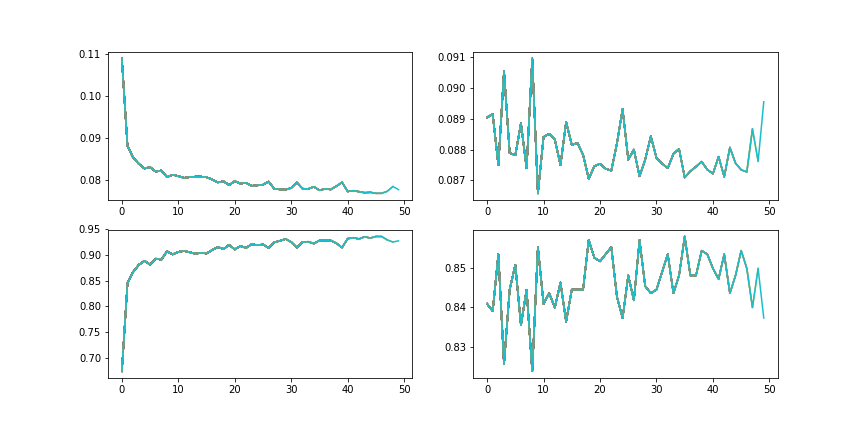

In [14]:
import time 
%matplotlib inline
%matplotlib notebook

fig = plt.figure(figsize=(12, 6))
train_loss_figure = fig.add_subplot(221)
test_loss_figure = fig.add_subplot(222)
train_acc_figure = fig.add_subplot(223)
test_acc_figure = fig.add_subplot(224)

plt.ion()
fig.show()
fig.canvas.draw()

epoch_list=[]
train_loss= []
test_loss=[]
train_acc= []
test_acc=[]

for epoch in range(num_epoches):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_test_loss = 0
    epoch_test_acc = 0
    
    # training step
    for i,(news,label) in enumerate(train_dataloader):
        news = news.type(torch.FloatTensor)
        news = Variable(news)

        label = label.type(torch.LongTensor)
        label = Variable(label)

        
        # feedfoward step
        out = nn_model(news)
        loss = criterion(out, label)
        epoch_train_loss += loss.data.sum()
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        epoch_train_acc += num_correct.data[0]

        
        # backpropogate step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
   
    
    # testing step
    for news,label in test_dataloader:
        news = news.type(torch.FloatTensor)
        news = Variable(news)

        label = label.type(torch.LongTensor)
        label = Variable(label)

        out = nn_model(news)
        loss = criterion(out, label)

        epoch_test_loss += loss.data.sum()
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        epoch_test_acc += num_correct.data[0]
    
    
    epoch_list.append(epoch)
    train_loss.append(epoch_train_loss/len(train_dataset))
    test_loss.append(epoch_test_loss/len(test_dataset))
    train_acc.append(epoch_train_acc/len(train_dataset))
    test_acc.append(epoch_test_acc/len(test_dataset))
    

    train_loss_figure.plot(epoch_list,train_loss) # fit the line
    test_loss_figure.plot(epoch_list,test_loss) # fit the line
    train_acc_figure.plot(epoch_list,train_acc) # fit the line
    test_acc_figure.plot(epoch_list,test_acc) # fit the line
    fig.canvas.draw()   # draw
    time.sleep(0.5)    #sleep
    
    


## Final result

In [15]:
print('Train Loss: {:.4f}, Acc: {:.4f}'.format(epoch_train_loss / (len(train_glove_vec)), epoch_train_acc / (len(
        train_glove_vec))))

print('Test Loss: {:.4f}, Acc: {:.4f}'.format(epoch_test_loss / (len(test_glove_vec)), epoch_test_acc / (len(
        test_glove_vec))))


Train Loss: 0.0776, Acc: 0.9278
Test Loss: 0.0896, Acc: 0.8373
